In [102]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers , activations , models , preprocessing , utils
import tensorflow as tf
from  sklearn.model_selection import train_test_split

In [103]:
#doc du lieu ve dang data-label
data=[]
label=[]
error=0
with open('yelp_labelled.csv','r') as f:
    for line in f:
        part = line.strip().strip(',').split(',')
        if len(part)<=1:
            error+=1
            continue
        if part[-1]!='0' and part[-1]!='1':
            error+=1
            continue
        data.append(", ".join(part[:-1]))
        label.append(int(part[-1]))
print('Read',len(data),'items, skiped',error,'error lines')
print('Label 0:',len(label)-sum(label),'Label 1:',sum(label))

Read 992 items, skiped 8 error lines
Label 0: 496 Label 1: 496


In [104]:
print(data[:5])
print(label[:5])

['Wow... Loved this place.', 'Crust is not good.', 'Not tasty and the texture was just nasty.', 'Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.', 'The selection on the menu was great and so were the prices.']
[1, 0, 0, 1, 1]


In [105]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(lower=True,split=' ')
tokenizer.fit_on_texts(data)
X = tokenizer.texts_to_sequences(data)
X = pad_sequences(X)
print(X[:5])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0 424 164   8  15]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0 582   7  12  16]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0  12 149   2   1 425   4  45 426]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 583
   73 289   1 584 290 893 894 180 895 896 427   2 164   9]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   1 165  35   1 109   4  22   2  26  27   1 166]]


In [106]:
print("input shape",X.shape)
n_vocab=len(tokenizer.word_index)+1
print('Vocab count',n_vocab)

input shape (992, 32)
Vocab count 2054


In [107]:
print(n_vocab)
print(X.shape[1])

2054
32


In [108]:
embed_dim = 128
hidden_size = 200
batch_size = 32

model = models.Sequential()
model.add(layers.Embedding(n_vocab, embed_dim, input_length = X.shape[1]))
#model.add(layers.LSTM(hidden_size,return_sequences = True))
model.add(layers.LSTM(hidden_size, return_sequences = True))
model.add(layers.LSTM(hidden_size))
model.add(layers.Dense(128,activation='sigmoid'))
model.add(layers.Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 32, 128)           262912    
                                                                 
 lstm_19 (LSTM)              (None, 32, 200)           263200    
                                                                 
 lstm_20 (LSTM)              (None, 200)               320800    
                                                                 
 dense_16 (Dense)            (None, 128)               25728     
                                                                 
 dense_17 (Dense)            (None, 2)                 258       
                                                                 
Total params: 872,898
Trainable params: 872,898
Non-trainable params: 0
_________________________________________________________________
None


In [109]:
#tách train test
Y = tf.keras.utils.to_categorical(label)
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size = 0.25, random_state = 36)

In [110]:
history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = 4, verbose = 1, validation_split=0.1)

Epoch 1/4
21/21 [==============================] - 7s 138ms/step - loss: 0.6960 - accuracy: 0.5067 - val_loss: 0.6872 - val_accuracy: 0.6933
Epoch 2/4
21/21 [==============================] - 2s 95ms/step - loss: 0.6191 - accuracy: 0.6921 - val_loss: 0.5153 - val_accuracy: 0.7867
Epoch 3/4
21/21 [==============================] - 1s 56ms/step - loss: 0.3695 - accuracy: 0.8460 - val_loss: 0.6084 - val_accuracy: 0.6533
Epoch 4/4
21/21 [==============================] - 1s 48ms/step - loss: 0.1476 - accuracy: 0.9567 - val_loss: 0.5933 - val_accuracy: 0.8133


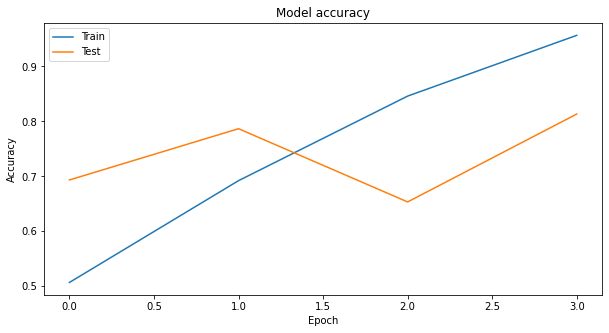

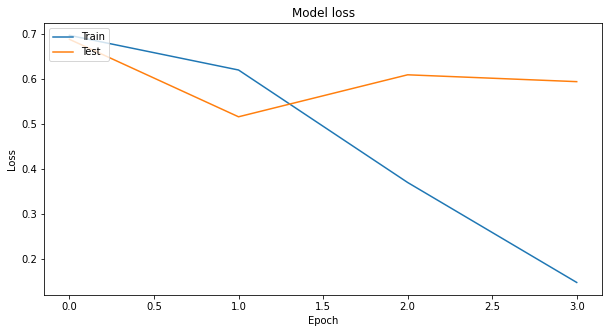

In [111]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 5)
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [112]:
#test
preds = model.predict(X_valid, verbose = 1)

8/8 [==============================] - 1s 4ms/step


In [113]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import numpy as np
#show result scores
predict_labels = preds.argmax(axis=-1)
true_labels=Y_valid.argmax(axis=-1)
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(true_labels, predict_labels)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(true_labels, predict_labels)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(true_labels, predict_labels)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(true_labels, predict_labels)
print('F1 score: %f' % f1)
predict_labels=np.append(predict_labels,1)
yhat4 = tf.keras.utils.to_categorical(predict_labels)
predict_labels=predict_labels[:-1]
yhat4=yhat4[:-1]
real = tf.keras.utils.to_categorical(true_labels)
print("\n".join(classification_report(real, yhat4).split('\n')[:4]))


Accuracy: 0.737903
Precision: 0.701389
Recall: 0.821138
F1 score: 0.756554
              precision    recall  f1-score   support

           0       0.79      0.66      0.72       125
           1       0.70      0.82      0.76       123
